In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import timm
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

🖥️  Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# Define paths - same as Notebook 1
BASE_PATH = '/content/drive/MyDrive/flickr30k_images'
IMAGES_PATH = BASE_PATH
PROCESSED_PATH = os.path.join(BASE_PATH, 'processed')

# Load dataset statistics
with open(os.path.join(PROCESSED_PATH, 'dataset_stats.json'), 'r') as f:
    dataset_stats = json.load(f)

print(f"\nDataset Statistics:")
print(f"   Training images: {dataset_stats['train_images']:,}")
print(f"   Validation images: {dataset_stats['val_images']:,}")
print(f"   Test images: {dataset_stats['test_images']:,}")
print(f"   Vocabulary size: {dataset_stats['vocabulary_size']:,}")
print(f"   Avg caption length: {dataset_stats['avg_caption_length_words']:.1f} words")
print(f"   Max caption length: {dataset_stats['max_caption_length_words']} words")


📊 Dataset Statistics:
   Training images: 18,000
   Validation images: 1,000
   Test images: 1,000
   Vocabulary size: 20,321
   Avg caption length: 13.4 words
   Max caption length: 82 words


In [ ]:
class Config:
    # Paths
    base_path = BASE_PATH
    images_path = IMAGES_PATH
    processed_path = PROCESSED_PATH

    # Image settings
    img_size = 224

    # Swin Transformer settings
    swin_model_name = 'swin_tiny_patch4_window7_224'
    swin_embed_dim = 768  # Swin-Tiny output dimension
    freeze_swin = True  # Freeze encoder for faster training

    # GPT-2 settings
    gpt2_model_name = 'gpt2'  # 117M parameters
    gpt2_embed_dim = 768  # GPT-2 embedding dimension
    max_length = 50  # Maximum caption length in tokens

    # Training settings
    batch_size = 64  # Adjust based on available memory
    num_workers = 2
    learning_rate = 5e-5
    num_epochs = 3

    # Special tokens
    bos_token = '<|startoftext|>'
    eos_token = '<|endoftext|>'
    pad_token = '<|pad|>'

    # Save settings
    checkpoint_dir = os.path.join(processed_path, 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Device
    device = device

config = Config()

print(f"\n Configuration:")
print(f"   Swin Model: {config.swin_model_name}")
print(f"   Swin Embed Dim: {config.swin_embed_dim}")
print(f"   Freeze Swin: {config.freeze_swin}")
print(f"   GPT-2 Model: {config.gpt2_model_name}")
print(f"   GPT-2 Embed Dim: {config.gpt2_embed_dim}")
print(f"   Max Caption Length: {config.max_length} tokens")
print(f"   Batch Size: {config.batch_size}")
print(f"   Learning Rate: {config.learning_rate}")
print(f"   Device: {config.device}")


📋 Configuration:
   Swin Model: swin_tiny_patch4_window7_224
   Swin Embed Dim: 768
   Freeze Swin: True
   GPT-2 Model: gpt2
   GPT-2 Embed Dim: 768
   Max Caption Length: 50 tokens
   Batch Size: 64
   Learning Rate: 5e-05
   Device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("Image transforms created")
print(f"   Train: Resize → Random Flip → Normalize")
print(f"   Val/Test: Resize → Normalize")

✓ Image transforms created
   Train: Resize → Random Flip → Normalize
   Val/Test: Resize → Normalize


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(config.gpt2_model_name)

# Add special tokens
special_tokens = {
    'pad_token': config.pad_token,
    'bos_token': config.bos_token,
    'eos_token': config.eos_token
}
tokenizer.add_special_tokens(special_tokens)

print(f"\n GPT-2 Tokenizer initialized")
print(f"   Vocabulary size: {len(tokenizer):,}")
print(f"   BOS token: '{config.bos_token}' (ID: {tokenizer.bos_token_id})")
print(f"   EOS token: '{config.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"   PAD token: '{config.pad_token}' (ID: {tokenizer.pad_token_id})")

# Test tokenization
test_caption = "A man in a blue shirt standing in a garden ."
test_tokens = tokenizer.encode(test_caption)
print(f"\n Tokenization test:")
print(f"   Input: '{test_caption}'")
print(f"   Tokens: {test_tokens}")
print(f"   Length: {len(test_tokens)} tokens")
print(f"   Decoded: '{tokenizer.decode(test_tokens)}'")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]


✓ GPT-2 Tokenizer initialized
   Vocabulary size: 50,259
   BOS token: '<|startoftext|>' (ID: 50258)
   EOS token: '<|endoftext|>' (ID: 50256)
   PAD token: '<|pad|>' (ID: 50257)

📝 Tokenization test:
   Input: 'A man in a blue shirt standing in a garden .'
   Tokens: [32, 582, 287, 257, 4171, 10147, 5055, 287, 257, 11376, 764]
   Length: 11 tokens
   Decoded: 'A man in a blue shirt standing in a garden .'


In [ ]:
class FlickrDataset(Dataset):
    """
    Custom Dataset for Flickr30k image captioning

    Returns:
        image: Transformed image tensor [3, 224, 224]
        caption: Tokenized caption with BOS/EOS tokens
        attention_mask: Mask for padding tokens
    """

    def __init__(self, captions_file, images_dir, transform, tokenizer, max_length):
        self.df = pd.read_csv(captions_file)
        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

        print(f"   Loaded {len(self.df):,} caption entries")
        print(f"   Unique images: {self.df['image'].nunique():,}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image and caption
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']

        # Load and transform image
        img_path = os.path.join(self.images_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image if loading fails
            image = torch.zeros(3, 224, 224)

        # Tokenize caption with BOS and EOS tokens
        caption_text = f"{self.tokenizer.bos_token} {caption} {self.tokenizer.eos_token}"

        # Encode caption
        encoding = self.tokenizer(
            caption_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        caption_ids = encoding['input_ids'].squeeze()  # [max_length]
        attention_mask = encoding['attention_mask'].squeeze()  # [max_length]

        return {
            'image': image,
            'caption_ids': caption_ids,
            'attention_mask': attention_mask,
            'caption_text': caption
        }

In [ ]:
print("\nCreating training dataset...")
train_dataset = FlickrDataset(
    captions_file=os.path.join(config.processed_path, 'train_captions.csv'),
    images_dir=config.images_path,
    transform=train_transform,
    tokenizer=tokenizer,
    max_length=config.max_length
)

print("\nCreating validation dataset...")
val_dataset = FlickrDataset(
    captions_file=os.path.join(config.processed_path, 'val_captions.csv'),
    images_dir=config.images_path,
    transform=val_transform,
    tokenizer=tokenizer,
    max_length=config.max_length
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"\n DataLoaders created:")
print(f"   Training batches: {len(train_loader):,}")
print(f"   Validation batches: {len(val_loader):,}")
print(f"   Batch size: {config.batch_size}")


📦 Creating training dataset...
   Loaded 90,000 caption entries
   Unique images: 18,000

📦 Creating validation dataset...
   Loaded 5,000 caption entries
   Unique images: 1,000

✓ DataLoaders created:
   Training batches: 1,407
   Validation batches: 79
   Batch size: 64


In [ ]:
sample_batch = next(iter(train_loader))

print(f"\nSample Batch:")
print(f"   Image shape: {sample_batch['image'].shape}")
print(f"   Caption IDs shape: {sample_batch['caption_ids'].shape}")
print(f"   Attention mask shape: {sample_batch['attention_mask'].shape}")

# Display first caption
print(f"\nFirst caption in batch:")
print(f"   Text: {sample_batch['caption_text'][0]}")
print(f"   Token IDs: {sample_batch['caption_ids'][0][:20].tolist()}...")
print(f"   Decoded: {tokenizer.decode(sample_batch['caption_ids'][0], skip_special_tokens=False)}")



📊 Sample Batch:
   Image shape: torch.Size([64, 3, 224, 224])
   Caption IDs shape: torch.Size([64, 50])
   Attention mask shape: torch.Size([64, 50])

📝 First caption in batch:
   Text: A young boy rides a red horse .
   Token IDs: [50258, 317, 1862, 2933, 17445, 257, 2266, 8223, 764, 220, 50256, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257]...
   Decoded: <|startoftext|> A young boy rides a red horse . <|endoftext|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>


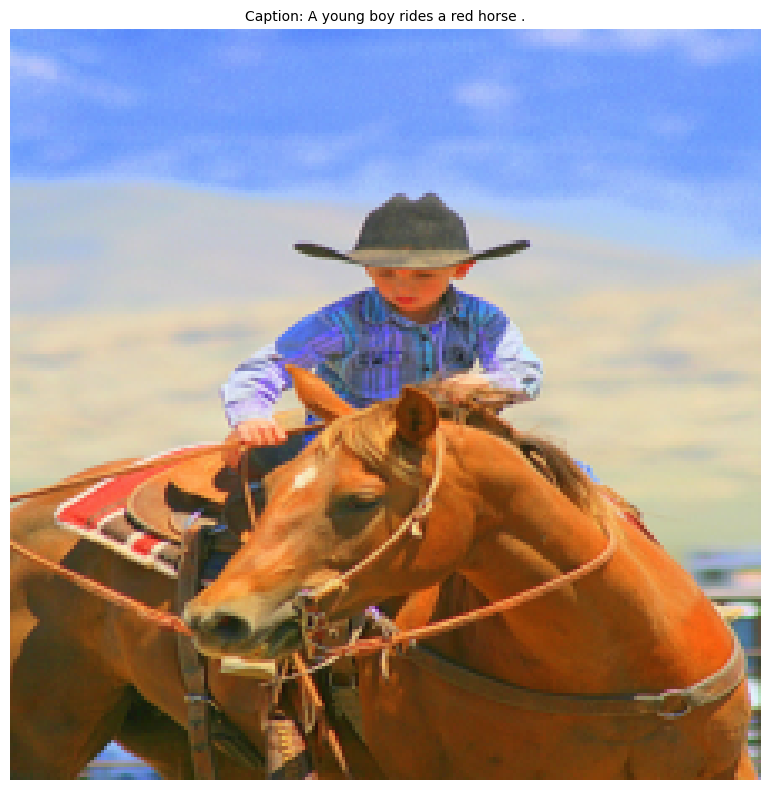


✓ Data loading test successful!


In [ ]:
img = sample_batch['image'][0]
# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_denorm = img * std + mean
img_denorm = torch.clamp(img_denorm, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(img_denorm.permute(1, 2, 0))
plt.title(f"Caption: {sample_batch['caption_text'][0]}", fontsize=10, wrap=True)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(config.processed_path, 'sample_batch_image.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n Data loading test successful!")

In [ ]:
class ImageCaptioningModel(nn.Module):
    """
    Image Captioning Model: Swin Transformer + GPT-2

    Architecture:
        1. Swin Transformer extracts image features [batch, 768]
        2. Projection layer maps to GPT-2 embedding space
        3. GPT-2 generates captions conditioned on image features
    """

    def __init__(self, config, tokenizer):
        super(ImageCaptioningModel, self).__init__()

        self.config = config
        self.tokenizer = tokenizer

        # 1. Image Encoder: Swin Transformer
        print("   Loading Swin Transformer...")
        self.swin = timm.create_model(
            config.swin_model_name,
            pretrained=True,
            num_classes=0  # Remove classification head
        )


        if config.freeze_swin:
            for param in self.swin.parameters():
                param.requires_grad = False
            print("Swin Transformer loaded and FROZEN")
        else:
            print("Swin Transformer loaded (trainable)")

        # 2. Projection Layer: Map Swin features to GPT-2 embedding space
        self.projection = nn.Linear(config.swin_embed_dim, config.gpt2_embed_dim)
        print(f"Projection layer created: {config.swin_embed_dim} → {config.gpt2_embed_dim}")

        # 3. Text Decoder: GPT-2
        print("Loading GPT-2...")
        self.gpt2 = GPT2LMHeadModel.from_pretrained(config.gpt2_model_name)

        # Resize token embeddings to account for new special tokens
        self.gpt2.resize_token_embeddings(len(tokenizer))
        print(f"GPT-2 loaded with vocabulary size: {len(tokenizer):,}")

        # 4. Image prefix projection to match GPT-2's expected sequence format
        # We'll add the image features as a "prefix" to the caption
        self.image_prefix_length = 1  # Treat image as 1 token

    def forward(self, images, caption_ids, attention_mask):
        """
        Forward pass

        Args:
            images: [batch_size, 3, 224, 224]
            caption_ids: [batch_size, max_length]
            attention_mask: [batch_size, max_length]

        Returns:
            logits: [batch_size, max_length, vocab_size]
        """
        batch_size = images.size(0)

        # 1. Extract image features with Swin
        with torch.set_grad_enabled(not self.config.freeze_swin):
            image_features = self.swin(images)  # [batch_size, 768]

        # 2. Project to GPT-2 embedding space
        image_embeds = self.projection(image_features)  # [batch_size, 768]
        image_embeds = image_embeds.unsqueeze(1)  # [batch_size, 1, 768]

        # 3. Get text embeddings from GPT-2
        caption_embeds = self.gpt2.transformer.wte(caption_ids)  # [batch_size, max_length, 768]

        # 4. Concatenate image embeddings with caption embeddings
        # Image acts as a "prefix" to the caption
        input_embeds = torch.cat([image_embeds, caption_embeds], dim=1)  # [batch_size, 1+max_length, 768]

        # 5. Create attention mask for the concatenated sequence
        image_attention = torch.ones(batch_size, 1, device=attention_mask.device)
        full_attention_mask = torch.cat([image_attention, attention_mask], dim=1)  # [batch_size, 1+max_length]

        # 6. Pass through GPT-2
        outputs = self.gpt2(
            inputs_embeds=input_embeds,
            attention_mask=full_attention_mask,
            return_dict=True
        )

        # 7. Get logits and remove the image prefix position
        logits = outputs.logits[:, self.image_prefix_length:, :]  # [batch_size, max_length, vocab_size]

        return logits

    def generate_caption(self, image, max_length=50, num_beams=5):
        """
        Generate caption for a single image using beam search

        Args:
            image: [3, 224, 224] tensor
            max_length: Maximum caption length
            num_beams: Number of beams for beam search

        Returns:
            caption: Generated caption string
        """
        self.eval()
        with torch.no_grad():

            if image.dim() == 3:
                image = image.unsqueeze(0)

            image = image.to(self.config.device)

            # Extract image features
            image_features = self.swin(image)
            image_embeds = self.projection(image_features).unsqueeze(1)

            # Start with BOS token
            input_ids = torch.tensor([[self.tokenizer.bos_token_id]], device=self.config.device)

            # Generate tokens autoregressively
            for _ in range(max_length):
                # Get caption embeddings
                caption_embeds = self.gpt2.transformer.wte(input_ids)

                # Concatenate with image
                input_embeds = torch.cat([image_embeds, caption_embeds], dim=1)

                # Forward pass
                outputs = self.gpt2(inputs_embeds=input_embeds, return_dict=True)

                # Get next token logits
                next_token_logits = outputs.logits[:, -1, :]
                next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)

                # Append to sequence
                input_ids = torch.cat([input_ids, next_token_id], dim=1)

                # Stop if EOS token is generated
                if next_token_id.item() == self.tokenizer.eos_token_id:
                    break

            # Decode caption
            caption = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)

        return caption

print("\n ImageCaptioningModel class defined")



✓ ImageCaptioningModel class defined


In [ ]:

# Create model
model = ImageCaptioningModel(config, tokenizer)
model = model.to(config.device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Frozen parameters: {total_params - trainable_params:,}")
print(f"   Percentage trainable: {trainable_params/total_params*100:.2f}%")

   Loading Swin Transformer...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

   ✓ Swin Transformer loaded and FROZEN
   ✓ Projection layer created: 768 → 768
   Loading GPT-2...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


   ✓ GPT-2 loaded with vocabulary size: 50,259

📊 Model Statistics:
   Total parameters: 152,551,290
   Trainable parameters: 125,031,936
   Frozen parameters: 27,519,354
   Percentage trainable: 81.96%


In [ ]:
test_batch = next(iter(train_loader))
test_images = test_batch['image'][:4].to(config.device)
test_caption_ids = test_batch['caption_ids'][:4].to(config.device)
test_attention_mask = test_batch['attention_mask'][:4].to(config.device)

print(f"\n Test batch shapes:")
print(f"   Images: {test_images.shape}")
print(f"   Caption IDs: {test_caption_ids.shape}")
print(f"   Attention mask: {test_attention_mask.shape}")

# Forward pass
model.eval()
with torch.no_grad():
    logits = model(test_images, test_caption_ids, test_attention_mask)

print(f"\nForward pass successful!")
print(f"   Output logits shape: {logits.shape}")
print(f"   Expected: [batch_size={4}, max_length={config.max_length}, vocab_size={len(tokenizer)}]")

# Test loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

loss = criterion(logits.reshape(-1, len(tokenizer)), test_caption_ids.reshape(-1))
print(f"\n   Test loss: {loss.item():.4f}")


📊 Test batch shapes:
   Images: torch.Size([4, 3, 224, 224])
   Caption IDs: torch.Size([4, 50])
   Attention mask: torch.Size([4, 50])

✓ Forward pass successful!
   Output logits shape: torch.Size([4, 50, 50259])
   Expected: [batch_size=4, max_length=50, vocab_size=50259]

   Test loss: 8.9167


In [ ]:

# Generate caption for first test image (before training)
test_image = test_batch['image'][0]
original_caption = test_batch['caption_text'][0]

print(f"\nOriginal caption: '{original_caption}'")
print(f"\nGenerating caption (untrained model)...")

generated_caption = model.generate_caption(test_image, max_length=30)
print(f"   Generated: '{generated_caption}'")
print(f"\n   Note: This is random since model is untrained!")


📝 Original caption: 'Three dogs stare curiously at a chewed up toy'

🤖 Generating caption (untrained model)...
   Generated: '.

The study, which was published in the journal PLOS ONE, found that the risk of developing a heart attack was reduced by a factor'

   Note: This is random since model is untrained!


In [ ]:

print(f"\n Summary:")
print(f"   ✓ Datasets created: {len(train_dataset):,} train, {len(val_dataset):,} val")
print(f"   ✓ DataLoaders ready: {len(train_loader)} train batches, {len(val_loader)} val batches")
print(f"   ✓ Model initialized: {trainable_params:,} trainable parameters")
print(f"   ✓ Forward pass tested: Output shape {logits.shape}")
print(f"   ✓ Caption generation tested")

print(f"\n Files saved:")
print(f" sample_batch_image.png")


✅ Summary:
   ✓ Datasets created: 90,000 train, 5,000 val
   ✓ DataLoaders ready: 1407 train batches, 79 val batches
   ✓ Model initialized: 125,031,936 trainable parameters
   ✓ Forward pass tested: Output shape torch.Size([4, 50, 50259])
   ✓ Caption generation tested

📁 Files saved:
   • sample_batch_image.png
